### Actual Data Pull From Snowflake

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import dataio
pd.set_option('max.columns', None)
pd.set_option('max.rows',None)

profile = dataio.SnowflakeProfile(name='kkurek@uplift.com')
dm_snowflake = dataio.SnowflakeDataManager(profile)

# User name: kkurek@uplift.com
# Private key path: /Users/kevinkurek/Desktop/rsa_key.p8
# Role: T_LENDING_FRAUD_PII
# Database: PRODUCTION_DB or ANALYTICS_DB
# Warehouse: ADHOC_WH
# Key encryption password:········

# Dan pre = previous transaction logic & if; checking previous payment token
df_ = dm_snowflake.query("""
select txn_timestamp, loan_id, application_id, hour, dayofweek, transaction_provider,
        pre_txn_provider, transaction_status, txn_duration, provider_response_code,
        pre_response_code, type, bank, rsubtype, transaction_amount, financed_amount, term, fico,
        payment_index, destination_account, if_retry, if_mannual_pay, if_change_card, if_change_processor,
        direction_change_processor, monthly_vintage, isocountry
        
from ANALYTICS_DB.DEV.DS_FCS_CARD_TXN_V
where txn_timestamp > '2019-01-01'
order by txn_timestamp""")
print(df_.shape)
display(df_.head())
df_.to_csv("static_processor_data_20201002.csv")

Key encryption password: ········
(2488733, 27)


,txn_timestamp,loan_id,application_id,hour,dayofweek,transaction_provider,pre_txn_provider,transaction_status,txn_duration,provider_response_code,pre_response_code,type,bank,rsubtype,transaction_amount,financed_amount,term,fico,payment_index,destination_account,if_retry,if_mannual_pay,if_change_card,if_change_processor,direction_change_processor,monthly_vintage,isocountry
0,2019-01-01 00:15:26.591,34847745,C48403104270,0,Tue,Stripe,None,SUCCEEDED,NaN,succeeded,None,None,None,card-sale,413.85,3978.61,11,634.0,2,milo,0,0,0,0,None,2018-11,None
1,2019-01-01 00:29:12.289,33336403,C33300556071,0,Tue,Stripe,None,SUCCEEDED,NaN,succeeded,None,None,None,card-sale,29.08,274.11,11,554.0,5,fortress1,0,0,0,0,None,2018-8,None
2,2019-01-01 00:41:53.190,33045661,C30414044839,0,Tue,Stripe,None,SUCCEEDED,NaN,succeeded,None,None,None,card-sale,74.00,697.49,11,597.0,4,fortress1,0,1,0,0,None,2018-7,None
3,2019-01-01 00:42:51.711,32018809,C20123004365,0,Tue,Stripe,None,SUCCEEDED,NaN,succeeded,None,None,None,card-sale,140.34,1312.10,11,607.0,6,fortress1,0,1,0,0,None,2018-5,None
4,2019-01-01 01:05:23.136,32644150,C26421532240,1,Tue,Stripe,None,SUCCEEDED,NaN,succeeded,None,None,None,card-sale,50.00,273.84,6,558.0,4,milo,0,1,0,0,None,2018-6,None


### Clean for MAB
Data is saved to: preprocessed_MAB_data.csv

In [4]:
import pandas as pd
import numpy as np
from collections import Counter
import dataio
pd.set_option('max.columns', None)
pd.set_option('max.rows',None)

# Clean for baseline MAB
df_orig = pd.read_csv("static_processor_data_20201002.csv", index_col=0)
print(f"Original data shape: {df_orig.shape}")

# Lets focus on the USA for now, and only a few primary columns to test if a MAB learns along with some EDA
df_orig = df_orig[df_orig['isocountry']=='UNITED STATES']

# Only rows with not null bank value
df_orig = df_orig[df_orig['bank'].notna()]

# Define df_ which means no retries
df_ = df_orig[df_orig['if_retry']==0]
print(f"No Retry data shape: {df_.shape}")
display(df_.head(3))
df_.to_csv("CMAB_data_NoRetry.csv")

# Define df_retry into retries
df_retry = df_orig[df_orig['if_retry']!=0]
print(f"Yes Retry data shape: {df_retry.shape}")
display(df_retry.head(3))
df_retry.to_csv("CMAB_data_YesRetry.csv")

# Only focuses on core MAB necessary columns; features for contextual MAB will be added later
df_ = df_.loc[:,['txn_timestamp', 'application_id', 'transaction_provider',
                'hour', 'dayofweek', 'rsubtype', 'transaction_status']]

# Define Reward Column
df_['reward'] = np.where(df_['transaction_status']=='SUCCEEDED', 1, 0)
print(Counter(df_['reward']), Counter(df_['transaction_provider']))
# display(df_.head())

# How many arms should we have; 3 * 24 * 7 = 504
print(len(df_['transaction_provider'].unique()), len(df_['hour'].unique()), len(df_['dayofweek'].unique()))

# Convert processor * hour * dayofweek to categorical numeric arms.
df_['arms'] = df_.groupby(['transaction_provider','hour','dayofweek']).ngroup()

# How many arms did we actually get: 502. Missing 2 combinations somewhere; likely never processed at that combo.
print(len(df_['arms'].unique()))

# Decoding of how each processor/hour/dayofweek maps to specific arm
decode_df = df_.drop_duplicates(['arms'], keep='first').sort_values(by='arms').reset_index(drop=True)
decode_df = decode_df[['transaction_provider','hour','dayofweek', 'arms']]
display(decode_df.head())
decode_df.to_csv("decode_arms.csv")

# Resulting df: timestamp  arms(movieid)  application_id(userId)  reward(liked)
df = df_[['txn_timestamp', 'arms', 'application_id', 'reward']]
df.head(3)

/Users/kevinkurek/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (12,13,25,27) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/kevinkurek/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Original data shape: (2488733, 27)
No Retry data shape: (1871795, 27)


,txn_timestamp,loan_id,application_id,hour,dayofweek,transaction_provider,pre_txn_provider,transaction_status,txn_duration,provider_response_code,pre_response_code,type,bank,rsubtype,transaction_amount,financed_amount,term,fico,payment_index,destination_account,if_retry,if_mannual_pay,if_change_card,if_change_processor,direction_change_processor,monthly_vintage,isocountry
73164,2019-04-05 23:33:50.463,34351289,C43516437946,23,Fri,Stripe,Stripe,SUCCEEDED,10.0,succeeded,succeeded,DEBIT,USAA,card-sale,1757.36,2987.57,11,632.0,6.0,fortress1,0,1,1,0,NaN,2018-10,UNITED STATES
73165,2019-04-05 23:34:31.855,32461270,C24623226959,23,Fri,Stripe,Stripe,SUCCEEDED,0.0,succeeded,do_not_honor,DEBIT,USAA SAVINGS BANK,card-sale,190.50,1882.19,11,717.0,4.0,fortress1,0,1,1,0,NaN,2018-6,UNITED STATES
73166,2019-04-05 23:40:53.843,40217938,D02103129260,23,Fri,Stripe,NaN,SUCCEEDED,NaN,succeeded,NaN,DEBIT,BMO HARRIS BANK N.A.,card-sale,270.51,322.88,11,718.0,1.0,fortress1,0,1,0,0,NaN,2019-1,UNITED STATES


Yes Retry data shape: (433162, 27)


,txn_timestamp,loan_id,application_id,hour,dayofweek,transaction_provider,pre_txn_provider,transaction_status,txn_duration,provider_response_code,pre_response_code,type,bank,rsubtype,transaction_amount,financed_amount,term,fico,payment_index,destination_account,if_retry,if_mannual_pay,if_change_card,if_change_processor,direction_change_processor,monthly_vintage,isocountry
73206,2019-04-06 01:04:42.306,33852310,C38513053546,1,Sat,Stripe,Stripe,ERRORED,0.0,insufficient_funds,do_not_honor,CREDIT,CREDIT ONE BANK N.A.,card-sale,106.24,1001.52,11,591.0,4.0,fortress1,1,1,1,0,NaN,2018-9,UNITED STATES
73208,2019-04-06 01:06:45.940,33852310,C38513053546,1,Sat,Stripe,Stripe,SUCCEEDED,0.0,succeeded,insufficient_funds,DEBIT,CAPITAL ONE BANK (USA) N.A.,card-sale,111.24,1001.52,11,591.0,4.0,fortress1,1,1,1,0,NaN,2018-9,UNITED STATES
73210,2019-04-06 01:11:37.658,34936973,C49320092522,1,Sat,Stripe,Stripe,ERRORED,1.0,succeeded,succeeded,DEBIT,PNC BANK N.A.,card-sale,171.10,1615.96,11,603.0,3.0,fortress1,1,1,0,0,NaN,2018-12,UNITED STATES


Counter({1: 1664103, 0: 207692}) Counter({'Stripe': 1388134, 'Wells Fargo': 470569, 'Chase': 13092})
3 24 7
502


,transaction_provider,hour,dayofweek,arms
0,Chase,0,Fri,0
1,Chase,0,Mon,1
2,Chase,0,Sat,2
3,Chase,0,Sun,3
4,Chase,0,Thu,4


,txn_timestamp,arms,application_id,reward
73164,2019-04-05 23:33:50.463,327,C43516437946,1
73165,2019-04-05 23:34:31.855,327,C24623226959,1
73166,2019-04-05 23:40:53.843,327,D02103129260,1


No Retry data shape: (1871795, 4)
126
150


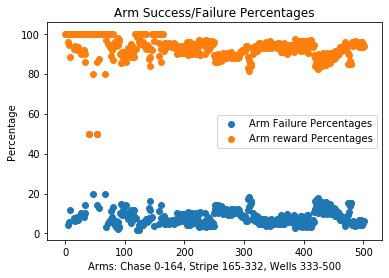

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Top 10 failed transaction arms by percentage
print(f"No Retry data shape: {df.shape}")
df_a = pd.DataFrame(df.groupby(['arms', 'reward'])['reward'].count()).rename(columns={'reward':'pct_counts'})
df_pct = df_a.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
df_pct = df_pct.reset_index()
# df_pct.head()

# Define Worst Arms
df_fail = df_pct[df_pct['reward']==0].sort_values(by='pct_counts', ascending=False)
worst_arms_df = df_fail[df_fail['pct_counts']>=10.0].reset_index(drop=True)
worst_arms = list(worst_arms_df['arms'])
print(len(worst_arms))
# display(df_fail.head(20))

# Define Best Arms
df_suc = df_pct[df_pct['reward']==1].sort_values(by='pct_counts', ascending=False)
best_arms_df = df_suc[df_suc['pct_counts']>=95.0].reset_index(drop=True)
best_arms = list(best_arms_df['arms'])
print(len(best_arms))
# display(best_arms)

# Make an arm by reward matrix based on count and pct_change
# corrMatrix = df_a.corr()
# sns.heatmap(corrMatrix, annot=True)
# plt.show()

# decode_df # Chase 0-164, Stripe 165-332, Wells 333-500
plt.scatter(df_fail['arms'], df_fail['pct_counts'], label='Arm Failure Percentages')
plt.scatter(df_suc['arms'], df_suc['pct_counts'], label='Arm reward Percentages')

plt.title("Arm Success/Failure Percentages")
plt.xlabel("Arms: Chase 0-164, Stripe 165-332, Wells 333-500")
plt.ylabel("Percentage")
plt.legend()
plt.show()

There are 81 processors with more than 5000 transaction attempts and at least a 60.0 reward rate.


,arms,reward,counts,pct_counts,transaction_provider,hour,dayofweek
0,299,1,5144,91.873549,Stripe,19,Fri
1,453,1,6055,91.492898,Wells Fargo,17,Fri
2,296,1,5605,90.975491,Stripe,18,Thu


There are 69 processors with more than 1000 transaction attempts and at least a 10.0 fail rate.


,arms,reward,counts,pct_counts,transaction_provider,hour,dayofweek
0,424,0,1584,17.522124,Wells Fargo,12,Wed
1,423,0,1536,17.330475,Wells Fargo,12,Tue
2,419,0,1399,16.385570,Wells Fargo,12,Mon


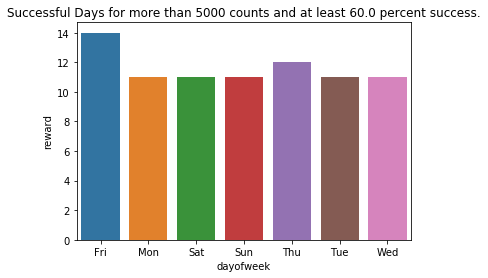

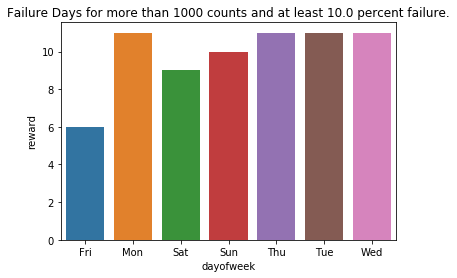

In [47]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

# Groupby to get a count of reward for each arm
df_a = pd.DataFrame(df.groupby(['arms', 'reward'])['reward'].count()).rename(columns={'reward':'counts'})
df_a = df_a.reset_index()

# Groupby to get a percentage of reward for each arm
df_pct = pd.DataFrame(df.groupby(['arms', 'reward'])['reward'].count()).rename(columns={'reward':'pct_counts'})
df_pct = df_pct.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
df_pct = df_pct.reset_index()

# Sort by most used counts then 
n_most_used_df = df_a.sort_values(by='counts', ascending=False) # [:100]
df_merged = n_most_used_df.merge(df_pct, on=['arms', 'reward'], how='inner')

# Merge decoding DF to see day, hour, processor
df_merged = df_merged.merge(decode_df, on=['arms'])
# display(df_merged[df_merged['arms']==310])


def arm_reward_analysis(df, reward_counts=10000, reward_pct=60.0, fail_counts=2000, fail_pct=10.0):
    
    # Subset reward DF and Fail DF
    df_suc = df[(df['counts']>reward_counts) & (df['pct_counts']>reward_pct) & (df['reward']==1)]
    df_fail = df[(df['counts']>fail_counts) & (df['pct_counts']>fail_pct) & (df['reward']==0)]
    
    # Sort and Merge reward
    df_suc = df_suc.sort_values(by=['pct_counts', 'counts'], ascending=False).reset_index(drop=True)
    print(f"There are {len(df_suc)} processors with more than {reward_counts} transaction attempts and at least a {reward_pct} reward rate.")
    display(df_suc.head(3))
    
    # Sort and Merge Failures
    df_fail = df_fail.sort_values(by=['pct_counts', 'counts'], ascending=False).reset_index(drop=True)
    print(f"There are {len(df_fail)} processors with more than {fail_counts} transaction attempts and at least a {fail_pct} fail rate.")
    display(df_fail.head(3))

    # Groupby day reward and failure
    df_suc_day = pd.DataFrame(df_suc.groupby(['dayofweek'])['reward'].count())
#     display(df_suc_day)
#     print(f"Most reward days are: \n {df_suc_day}")
    sns.barplot(x=df_suc_day.index, y=df_suc_day["reward"])
    plt.title(f"Successful Days for more than {reward_counts} counts and at least {reward_pct} percent success.")
    plt.show()
    df_fail_day = pd.DataFrame(df_fail.groupby(['dayofweek'])['reward'].count())
#     print(f"Most reward days are: \n {df_fail_day}")
    sns.barplot(x=df_fail_day.index, y=df_fail_day["reward"])
    plt.title(f"Failure Days for more than {fail_counts} counts and at least {fail_pct} percent failure.")
    plt.show()
    
    return df_suc, df_fail


best_arms, worst_arms = arm_reward_analysis(df_merged, reward_counts=5000, reward_pct=60.0, fail_counts=1000, fail_pct=10.0)

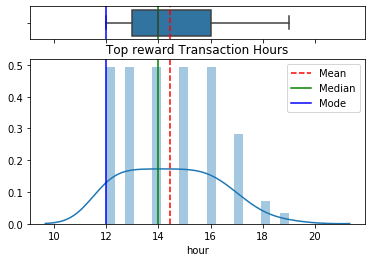

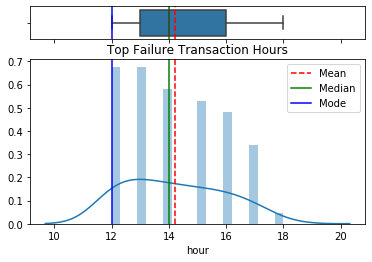

In [48]:
#####
# Hour analysis
#####

def box_hist(df, col_of_interest, reward_counts=5000, reward_pct=60.0, fail_counts=1000, fail_pct=10.0):
    
    # Subset reward DF and Fail DF ordered by percentage of reward
    df_suc = df[(df['counts']>reward_counts) & (df['pct_counts']>reward_pct) & (df['reward']==1)]
    df_suc = df_suc.sort_values(by=['pct_counts', 'counts'], ascending=False).reset_index(drop=True)
    
    df_fail = df[(df['counts']>fail_counts) & (df['pct_counts']>fail_pct) & (df['reward']==0)]
    df_fail = df_fail.sort_values(by=['pct_counts', 'counts'], ascending=False).reset_index(drop=True)
    
    df_list = [df_suc, df_fail]
    
    for df_ in df_list:
        f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})
        mean=df_[col_of_interest].mean()
        median=df_[col_of_interest].median()
        mode=df_[col_of_interest].mode().tolist()[0]
#         print(mode)
        
        if df_.equals(df_suc):
            plt.title("Top reward Transaction Hours")
        else:
            plt.title("Top Failure Transaction Hours")

        sns.boxplot(df_[col_of_interest], ax=ax_box)
        ax_box.axvline(mean, color='r', linestyle='--')
        ax_box.axvline(median, color='g', linestyle='-')
        ax_box.axvline(mode, color='b', linestyle='-')

        sns.distplot(df_[col_of_interest], ax=ax_hist, bins=20)
        ax_hist.axvline(mean, color='r', linestyle='--')
        ax_hist.axvline(median, color='g', linestyle='-')
        ax_hist.axvline(mode, color='b', linestyle='-')

        plt.legend({'Mean':mean,'Median':median,'Mode':mode})

        ax_box.set(xlabel='')
        plt.show()
    return
box_hist(df=df_merged, col_of_interest='hour', reward_counts=5000, reward_pct=60.0, fail_counts=1000, fail_pct=10.0)

In [215]:
# Arm we've failed on the most is Stripe + 8pm + Monday.
# decode_df[decode_df['arms']==306]

In [214]:
# # Worst Arms
# display(decode_df[decode_df['arms'].isin(worst_arms)])

# # Best Arms
# display(decode_df[decode_df['arms'].isin(best_arms)])

### Replay & UCB Function Defintions

In [23]:
# Conditioning on UCB based on Volume, is it inherently in there?

# ARM: processor * hour * dayofweek
# REWARD: transaction rewardful or not
# ACTION: processor to show
# STEP: number of values to step through for each period of time
TIMESTAMP = 'txn_timestamp'
ARM = 'arms'
ID = 'application_id'
REWARD = 'reward'

# Only use the best arms and worst arms to test MAB
concat_best_worst = list(best_arms['arms']) + list(worst_arms['arms'])
print(concat_best_worst)
df = df[df['arms'].isin(concat_best_worst)]
display(df.head())

# decode_df # Chase 0-164, Stripe 165-332, Wells 333-500
def replay_score(history, df, t, batch_size, recs):
    """
    https://arxiv.org/pdf/1003.5956.pdf
    replay score. reward if rec matches logged data, ignore otherwise.
    I.E. If MAB recommended 5 movies & historical viewer data showed they watched 3 of the 5 then we'd
    only pull the rewards for the 3 movies they played; [1, 0, 1] = liked, disliked, liked for example.
    """
    # reward if rec matches logged data, ignore otherwise
    actions = df[t:t+batch_size] # 100 possible processor matches at once
    # Core of "Reply": Matching our bandit policy recommendations with actual viewer content at current timestep
    actions = actions.loc[actions[ARM].isin(recs)] # Number out of 100 movies that matched
    actions['scoring_round'] = t
    # add row to history if recs match logging policy
    history = history.append(actions) # cumulatively grows as algo steps through time
    action_liked = actions[[ARM, REWARD]]
    return history, action_liked

[278, 273, 271, 446, 439, 432, 264, 280, 257, 266, 425, 292, 285, 274, 250, 281, 287, 288, 267, 272, 275, 259, 289, 286, 276, 282, 277, 291, 283, 290, 284, 268, 265, 270, 279, 252, 269, 260, 261, 253, 258, 263, 254, 262, 255, 251, 256, 256, 251, 255, 262, 254, 263, 258, 253, 261, 260, 269, 252, 279, 270, 265, 268, 284, 290, 283, 291, 277, 282, 276, 286, 289, 259, 275, 272, 267, 288, 287, 281, 250, 274, 285, 292, 425, 266, 257, 280]


,txn_timestamp,arms,application_id,reward
73273,2019-04-06 12:00:15.178,252,C10618161513,1
73274,2019-04-06 12:01:05.659,252,C14502252365,1
73275,2019-04-06 12:01:18.963,252,C18718182379,1
73276,2019-04-06 12:01:32.658,252,C14517199904,0
73279,2019-04-06 12:03:40.853,252,C14501387178,1


### Run Random Policy

In [24]:
NUM_RECS_AT_ONCE = 1 # ACTION: number of processors to show at once; NFLX shows 5 at once, for example.
BATCH_SIZE = 100 # STEP: number of values to step through at a time (note that 1 step at a time isn't efficient)

# initialize empty history for random policy
# (the algorithm should be able to see all events and outcomes prior to the current timestep, but no current or future outcomes)
history = pd.DataFrame(data=None, columns=df.columns)

# initialize empty list for storing scores from each step
random_rewards = []

for t in range(df.shape[0]//BATCH_SIZE):
    t = t * BATCH_SIZE
#     POLICY: generate recommendations from a random policy
    recs = np.random.choice(df[ARM].unique(), size=NUM_RECS_AT_ONCE, replace=False)

#     print(recs) # Number of processors by ID
    # send recommendations and dataset to a scoring function so the model can learn & adjust its policy in the next iteration
    history, action_score = replay_score(history, df, t, BATCH_SIZE, recs)
#     print(f"Current history: \n {history} \n")
#     print(f"Current action: \n {action_score} \n")
    
    if action_score is not None:
        action_score = action_score[REWARD].tolist() # REWARD Pulls out 1 or 0, reward or not
        random_rewards.extend(action_score)
#         print(f"Cumulative Rewards at time t = {t}: \n {rewards} \n")  

random_cumulative_rewards = np.cumsum(random_rewards)
print(random_cumulative_rewards)
random_trailing_ctr = np.asarray(pd.Series(random_rewards).rolling(50).mean())
print(random_trailing_ctr)

[    1     1     2 ... 25334 25335 25336]
[ nan  nan  nan ... 0.94 0.94 0.94]


### Run Epsilon Greedy

In [25]:
NUM_RECS_AT_ONCE = 1 # ACTION: number of processors to show at once; NFLX shows 5 at once, for example.
BATCH_SIZE = 100 # STEP: number of values to step through at a time (note that 1 step at a time isn't efficient)
EPSILON = 0.15

def epsilon_greedy_policy(df, arms, epsilon=0.15, slate_size=1, batch_size=100):
    '''
    df: dataset to apply the policy to
    epsilon: float. represents the % of timesteps where we explore random arms
    slate_size: int. the number of recommendations to make at each step.
    batch_size: int. the number of users to serve these recommendations to before updating the bandit's policy.
    '''
    # draw a 0 or 1 from a binomial distribution, with epsilon% likelihood of drawing a 1
    explore = np.random.binomial(1, epsilon)
    # if explore: shuffle movies to choose a random set of recommendations
    if explore == 1 or df.shape[0]==0:
        recs = np.random.choice(arms, size=(slate_size), replace=False)
    # if exploit: sort movies by "like rate", recommend movies with the best performance so far
    else:
        scores = df[[ARM, REWARD]].groupby(ARM).agg({REWARD: ['mean', 'count']})
        scores.columns = ['mean', 'count']
        scores[ARM] = scores.index
        scores = scores.sort_values('mean', ascending=False)
        recs = scores.loc[scores.index[0:slate_size], ARM].values
    return recs

# initialize empty history 
# (offline eval means you can only add to history when rec matches historic data)
history = pd.DataFrame(data=None, columns=df.columns)
history = history.astype({ARM: 'int32', REWARD: 'float'})

# to speed this up, retrain the bandit every batch_size time steps
# this lets us measure batch_size actions against a slate of recommendations rather than generating
#      recs at each time step. this seems like the only way to make it through a large dataset like
#      this and get a meaningful sample size with offline/replay evaluation
print("Running Algorithm...")
ep_rewards = []
max_time = df.shape[0] # total number of ratings to evaluate using the bandit
for t in range(max_time//BATCH_SIZE): #df.t:
    t = t * BATCH_SIZE
    # choose which arm to pull
    recs = epsilon_greedy_policy(df=history.loc[history.index<=t,], arms=df[ARM].unique(),
                                 epsilon=EPSILON, slate_size=NUM_RECS_AT_ONCE, batch_size=BATCH_SIZE)
    history, action_score = replay_score(history, df, t, BATCH_SIZE, recs)
    if action_score is not None:
        action_score = action_score[REWARD].tolist()
        ep_rewards.extend(action_score)
        
ep_cumulative_rewards = np.cumsum(ep_rewards)
print(ep_cumulative_rewards)
ep_trailing_ctr = np.asarray(pd.Series(ep_rewards).rolling(50).mean())
print(ep_trailing_ctr)

Running Algorithm...
[    1     1     1 ... 30809 30810 30811]
[ nan  nan  nan ... 0.92 0.92 0.92]


### Run UCB Bayesian Policy

In [26]:
NUM_RECS_AT_ONCE = 1 # ACTION: number of processors to show at once; NFLX shows 5 at once, for example.
BATCH_SIZE = 100 # STEP: number of values to step through at a time (note that 1 step at a time isn't efficient)

# initialize history for UCB Policy
# initialze history with 50% reward rate, 8 ratings
# this avoids stddev errors and prioritizes exploration of new posts in early iterations
history = df.groupby(ARM).first()
history[ARM] = history.index
history['t'] = 0
history.index = history['t']
history[REWARD] = 1
history = history[df.columns] # reorder columns to match logged data
history2 = history.copy()
history2[REWARD] = 0
history = history.append(history).append(history2)
history['scoring_round'] = 0
display(history.head())
# history = pd.DataFrame(data=None, columns=df.columns)


def ucb1_policy(df, t, ucb_scale=2.0, slate_size=1, bayes=True):
    '''
    Applies UCB1 policy to generate movie recommendations
    Args:
        df: dataframe. Dataset to apply UCB policy to.
        ucb_scale: float. Most implementations use 2.0.
        t: int. represents the current time step.
    '''
    scores = df[[ARM, REWARD]].groupby(ARM).agg({REWARD: ['mean', 'count', 'std']})
    scores.columns = ['mean', 'count', 'std']
    if bayes:
        # Bayes UCB
        scores['ucb'] = scores['mean'] + (ucb_scale * scores['std'] / np.sqrt(scores['count']))
    else:
        # Regular UCB
        scores['ucb'] = scores['mean'] + np.sqrt(
                ( (2 * np.log10(t)) /
                    scores['count'] )
                )
    scores[ARM] = scores.index
    scores = scores.sort_values('ucb', ascending=False)
    recs = scores.loc[scores.index[0:slate_size], ARM].values
    return recs


# to speed this up, retrain the bandit every batch_size time steps
# this lets us measure batch_size actions against a slate of recommendations rather than generating
#      recs at each time step. this becomes necessary to reach a useful sample size with replay evaluation
# ucb_history = pd.DataFrame(data=None, columns = ['mean', 'count', 'std', 'ucb', ARM, 'iter']) # for post-analysis of ucbs over iterations
max_time = df.shape[0] # total number of ratings to evaluate using the bandit
print('Running algorithm')

# initialize empty list for storing scores from each step
bayes_rewards = []

for t in range(max_time//BATCH_SIZE):
    t = t * BATCH_SIZE
    # POLICY: generate recommendations from a random policy
#     recs = np.random.choice(df.movieId.unique(), size=(slate_size), replace=False)

    # POLICY: Bayesian UCB
    recs = ucb1_policy(df=history.loc[history.index<=t,], t=t/BATCH_SIZE, ucb_scale=2.0,
                       slate_size=NUM_RECS_AT_ONCE, bayes=True)
#     print(recs) # Number of processors
    # send recommendations and dataset to a scoring function so the model can learn & adjust its policy in the next iteration
    history, action_score = replay_score(history, df, t, BATCH_SIZE, recs)
#     print(f"Current history: \n {history} \n")
#     print(f"Current action: \n {action_score} \n")
    
    if action_score is not None:
        action_score = action_score[REWARD].tolist() # REWARD Pulls out 1 or 0, liked or disliked
        bayes_rewards.extend(action_score)
#         print(f"Cumulative Rewards at time t = {t}: \n {rewards} \n")  

bayes_cumulative_rewards = np.cumsum(bayes_rewards)
print(bayes_cumulative_rewards)
bayes_trailing_ctr = np.asarray(pd.Series(bayes_rewards).rolling(50).mean())
print(bayes_trailing_ctr)

,txn_timestamp,arms,application_id,reward,scoring_round
t,,,,,
0,2019-04-12 12:01:53.879,250,C15423516242,1,0
0,2019-04-08 12:01:32.119,251,C19202273576,1,0
0,2019-04-06 12:00:15.178,252,C10618161513,1,0
0,2019-04-07 12:01:31.502,253,C19120135500,1,0
0,2019-04-11 12:01:14.123,254,C15323449900,1,0


Running algorithm
[    1     2     3 ... 37476 37477 37478]
[ nan  nan  nan ... 0.92 0.92 0.92]


20000
20000
20000


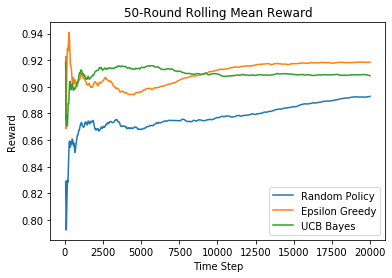

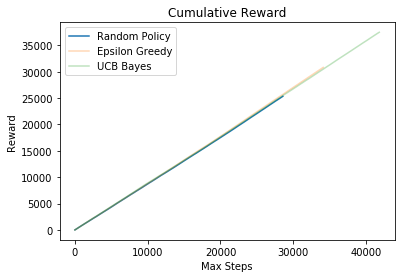

In [39]:
import matplotlib.pyplot as plt

# random_rewards = random_rewards[~np.isnan(random_rewards)]
# bayes_rewards = bayes_rewards[~np.isnan(bayes_rewards)]
# np.asarray(pd.Series(random_rewards).rolling(50).mean())

last_n_records = 20000

cumulative_random = np.cumsum(random_rewards[-last_n_records:]) / np.linspace(1, last_n_records, last_n_records)
print(len(cumulative_random))
cumulative_epsilon = np.cumsum(ep_rewards[-last_n_records:]) / np.linspace(1, last_n_records, last_n_records)
print(len(cumulative_epsilon))
cumulative_bayes = np.cumsum(bayes_rewards[-last_n_records:]) / np.linspace(1, last_n_records, last_n_records)
print(len(cumulative_bayes))


plt.plot(pd.Series(cumulative_random).rolling(50).mean(), label='Random Policy')
plt.plot(pd.Series(cumulative_epsilon).rolling(50).mean(), label='Epsilon Greedy')
plt.plot(pd.Series(cumulative_bayes).rolling(50).mean(), label='UCB Bayes')

plt.title('50-Round Rolling Mean Reward')
plt.xlabel('Time Step')
plt.ylabel('Reward')
plt.legend()
plt.show()

plt.plot(random_cumulative_rewards, label='Random Policy')
plt.plot(ep_cumulative_rewards, label='Epsilon Greedy', alpha=0.3)
plt.plot(bayes_cumulative_rewards, label='UCB Bayes', alpha=0.3)

plt.title('Cumulative Reward')
plt.xlabel('Max Steps')
plt.ylabel('Reward')
plt.legend()
plt.show()

In [ ]:
# BEST & WORST ARMS ONLY


# ALL DATA
# NUM_RECS_AT_ONCE = 1
# BATCH_SIZE = 100
# Random
# 4568
# .7
# UCB
# 177
# 1.

# NUM_RECS_AT_ONCE = 1
# BATCH_SIZE = 10000
# Random
# 4003
# 0.94
# UCB
# 181
# .96

# NUM_PROCESSOR = 5
# BATCH_Size = 1000
# ucb 1.0 = .74, 4512
# ucb 2.0 = .9, 13452
# ucb 3.0 = .62, 13483